In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import cmocean.cm as cmo
from xmitgcm import open_mdsdataset
from scipy.signal import detrend


In [2]:
filename_state = 'diag_state'
filename_surf = 'diag_surf'

# data_dir = '/data/SO3/edavenport/tpose6/nov2012/run_iter0/'
data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_withhold/run_iter14/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state, filename_surf]
ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds['XC'] = ds.XC.astype(float)
ds['YC'] = ds.YC.astype(float)
ds['Z'] = ds.Z.astype(float)
ds['XG'] = ds.XG.astype(float)
ds['YG'] = ds.YG.astype(float)
ds['Zl'] = ds.Zl.astype(float)

# data_dir = '/data/SO3/edavenport/tpose6/nov2012/run_iter0_noVelAssimIC/'
data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_assim/run_iter22/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state, filename_surf]
ds_vel = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds_vel['XC'] = ds.XC.astype(float)
ds_vel['YC'] = ds.YC.astype(float)
ds_vel['Z'] = ds.Z.astype(float)
ds_vel['XG'] = ds.XG.astype(float)
ds_vel['YG'] = ds.YG.astype(float)
ds_vel['Zl'] = ds.Zl.astype(float)

# data_dir = '/data/SO3/edavenport/tpose6/nov2012/run_iter0_noVelAssimIC/'
data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_assim/run_iter0/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state, filename_surf]
ds_noTAO = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds_noTAO['XC'] = ds.XC.astype(float)
ds_noTAO['YC'] = ds.YC.astype(float)
ds_noTAO['Z'] = ds.Z.astype(float)
ds_noTAO['XG'] = ds.XG.astype(float)
ds_noTAO['YG'] = ds.YG.astype(float)
ds_noTAO['Zl'] = ds.Zl.astype(float)

In [3]:
folder_name = '/home/edavenport/analysis/mitgcm-equatorial-waves/sst/'

### Wavenumber - Frequency (Avg over -5 to 5N)

In [4]:
latMin = -5
latMax = 5
lonMin = 165
lonMax = 260

sst = ds.ETAN.sel(XC=slice(lonMin,lonMax),YC=slice(latMin,latMax)).squeeze().compute()
sst_vel = ds_vel.ETAN.sel(XC=slice(lonMin,lonMax),YC=slice(latMin,latMax)).squeeze().compute()
sst_noTAO = ds_noTAO.ETAN.sel(XC=slice(lonMin,lonMax),YC=slice(latMin,latMax)).squeeze().compute()

# detrend, get anomaly
sst_detrend = detrend(sst,axis=0,type='linear') 
sst_anom = sst_detrend - np.nanmean(sst_detrend,axis=0)
sst_vel_detrend = detrend(sst_vel,axis=0,type='linear') 
sst_vel_anom = sst_vel_detrend - np.nanmean(sst_vel_detrend,axis=0)
sst_noTAO_detrend = detrend(sst_noTAO,axis=0,type='linear')
sst_noTAO_anom = sst_noTAO_detrend - np.nanmean(sst_noTAO_detrend,axis=0)

In [5]:
spectrum = np.abs(np.fft.fft2(sst_anom, axes=(0, 2)))**2  # power spectrum over (t, x)
spectrum_sst = sst.copy(deep=True)
spectrum_sst.values = spectrum
spectrum_sst_avg = spectrum_sst.mean(dim='YC')

spectrum = np.abs(np.fft.fft2(sst_vel_anom, axes=(0, 2)))**2  # power spectrum over (t, x)
spectrum_sst_vel = sst_vel.copy(deep=True)
spectrum_sst_vel.values = spectrum
spectrum_sst_vel_avg = spectrum_sst_vel.mean(dim='YC')

spectrum = np.abs(np.fft.fft2(sst_noTAO_anom, axes=(0, 2)))**2  # power spectrum over (t, x)
spectrum_sst_noTAO = sst_noTAO.copy(deep=True)
spectrum_sst_noTAO.values = spectrum
spectrum_sst_noTAO_avg = spectrum_sst_noTAO.mean(dim='YC')

nt = sst.sizes['time']
nx = sst.sizes['XC']

dt = 1  # time step
dx = float(ds['XC'].diff('XC').mean()) * 111.32       # spatial step, a more exact version would be 111.320 * cos(latitude) 

freqs = np.fft.fftfreq(nt, dt)  # cycles per unit time
wavenums = np.fft.fftfreq(nx, dx)  # cycles per unit distance

freqs = 1/(np.fft.fftshift(freqs))
wavenums = 1/(np.fft.fftshift(wavenums))
freqs[len(freqs)//2] = 0 # fix the inf value at the Nyquist frequency
wavenums[len(wavenums)//2] = 0
W, F = np.meshgrid(wavenums, freqs)  # W = wavenumber grid, F = frequency grids
pos_freq_idx = freqs > 0
pos_wavenum_idx = wavenums > 0
W_pos, F_pos = np.meshgrid(wavenums[pos_wavenum_idx], freqs[pos_freq_idx])

spectrum_sst_avg = np.fft.fftshift(spectrum_sst_avg, axes=(0, 1))  # shift freq and wavenumber dims
spectrum_sst_vel_avg = np.fft.fftshift(spectrum_sst_vel_avg, axes=(0, 1))  # shift freq and wavenumber dims
spectrum_sst_noTAO_avg = np.fft.fftshift(spectrum_sst_noTAO_avg, axes=(0, 1))  # shift freq and wavenumber dims

spec_sst_pos = spectrum_sst_avg[pos_freq_idx, :][:, pos_wavenum_idx]
spec_sst_vel_pos = spectrum_sst_vel_avg[pos_freq_idx, :][:, pos_wavenum_idx]
spec_sst_noTAO_pos = spectrum_sst_noTAO_avg[pos_freq_idx, :][:, pos_wavenum_idx]

In [6]:
# Constants
c = 2.7  # m/s, Kelvin wave speed

# Define wavelength in km
lambda_km = np.logspace(1, 4, 500)  # 10 km to 10,000 km
lambda_m = lambda_km * 1000  # convert to meters

# --- Kelvin wave ---
T_kelvin_days = (2 * np.pi * lambda_m) / (c * 86400)

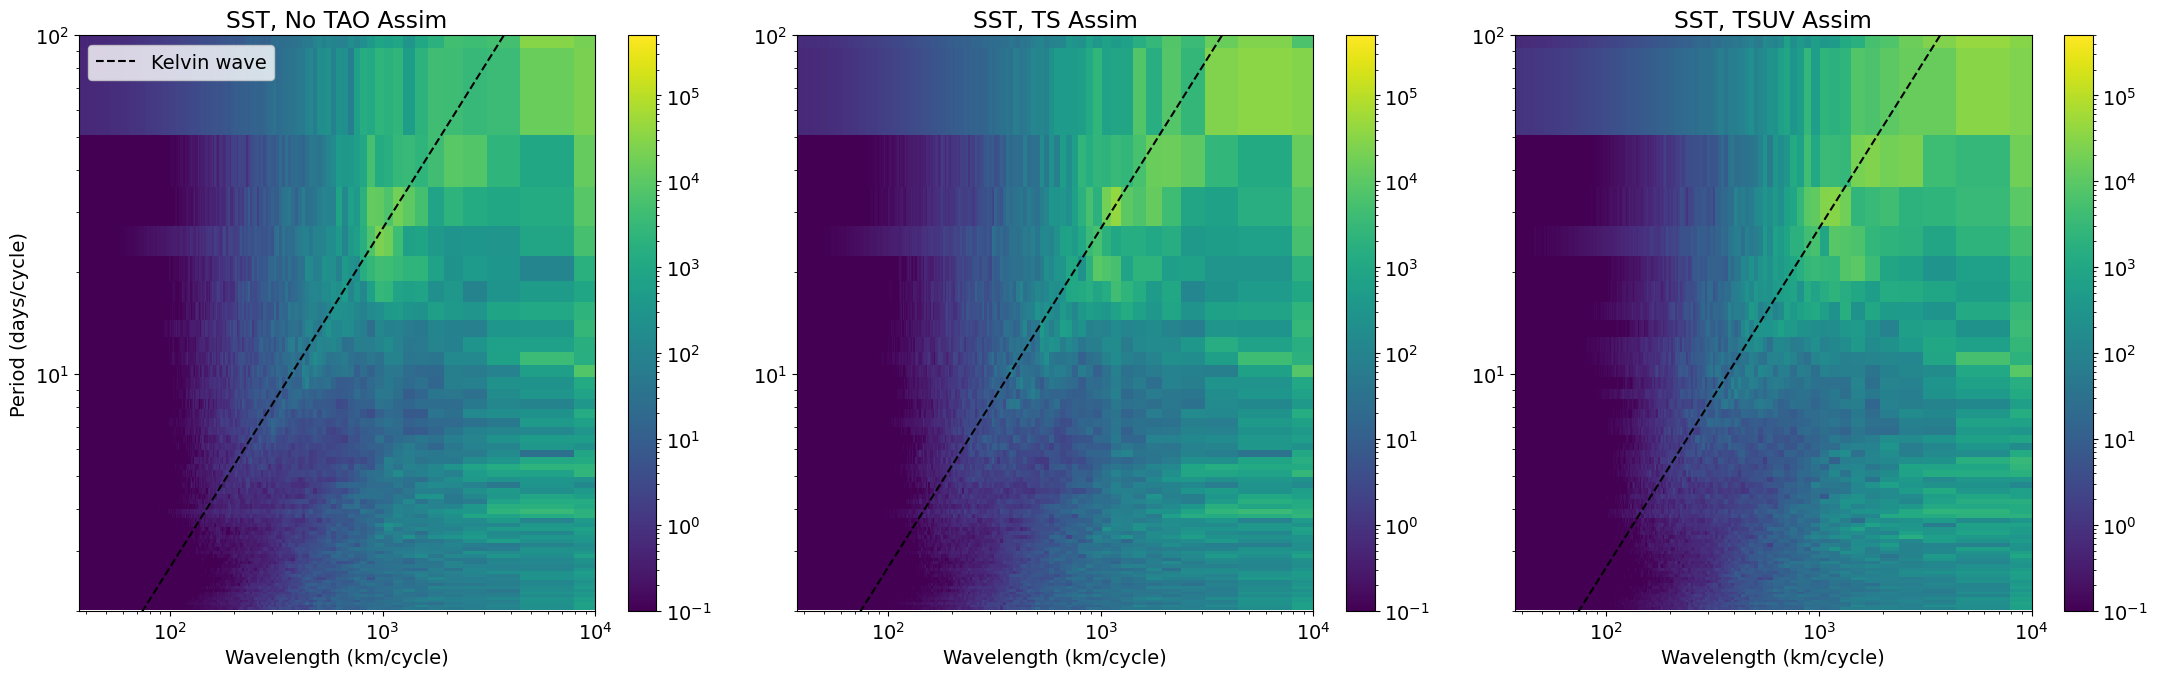

In [7]:
from matplotlib.colors import LogNorm
plt.rcParams['font.size'] = 14

vmin = 1e-1
vmax = 5e5
fig, ax = plt.subplots(figsize=(22, 7),ncols=3)
pcm = ax[0].pcolormesh(W_pos, F_pos, spec_sst_noTAO_pos, shading='auto', cmap='viridis', norm=LogNorm(vmin=vmin,vmax=vmax))
ax[0].plot(lambda_km, T_kelvin_days, label='Kelvin wave', color='black', linestyle='--',linewidth=1.5)
ax[0].loglog()
ax[0].legend()
ax[0].set_xlim(dx*2, 10000)  # Wavenumber in km/cycle
ax[0].set_ylim(2, 100)  # Frequency in days/cycle
ax[0].set_xlabel('Wavelength (km/cycle)')
ax[0].set_ylabel('Period (days/cycle)')
fig.colorbar(pcm, ax=ax[0])
ax[0].set_title('SST, No TAO Assim')

pcm = ax[1].pcolormesh(W_pos, F_pos, spec_sst_pos, shading='auto', cmap='viridis', norm=LogNorm(vmin=vmin,vmax=vmax))
ax[1].plot(lambda_km, T_kelvin_days, label='Kelvin wave', color='black', linestyle='--',linewidth=1.5)
ax[1].loglog()
ax[1].set_xlim(dx*2, 10000)  # Wavenumber in km/cycle
ax[1].set_ylim(2, 100)  # Frequency in days/cycle
ax[1].set_xlabel('Wavelength (km/cycle)')
fig.colorbar(pcm, ax=ax[1])
ax[1].set_title('SST, TS Assim')

pcm = ax[2].pcolormesh(W_pos, F_pos, spec_sst_vel_pos, shading='auto', cmap='viridis', norm=LogNorm(vmin=vmin,vmax=vmax))
ax[2].plot(lambda_km, T_kelvin_days, label='Kelvin wave', color='black', linestyle='--',linewidth=1.5)
ax[2].loglog()
ax[2].set_xlim(dx*2, 10000)  # Wavenumber in km/cycle
ax[2].set_ylim(2, 100)  # Frequency in days/cycle
ax[2].set_xlabel('Wavelength (km/cycle)')
fig.colorbar(pcm,ax=ax[2])
ax[2].set_title('SST, TSUV Assim')

plt.tight_layout()  # leave space at the top
fig.savefig(folder_name + 'sst_wavenumber_freq_5S5N.png')

#### Shutdown

In [8]:
cluster.close()
client.shutdown()
client.close()